Getting Started with GeoPandas
Written by Raechel Portelli 
10/18/2021

# Getting Set Up 

Import necessary packages. Note that you can do this as you need them, or import them all at the beginning of a project

In [489]:
import geopandas as gp
import pandas as pd 
import numpy as np
import fiona
import matplotlib.pyplot as plt
%matplotlib inline
from pyproj import CRS
from matplotlib_scalebar.scalebar import ScaleBar


Add the shapefile or shapefiles you would like to work on.

In [490]:
stateParks_gdf = gp.read_file("C:/Users/raechel/Desktop/stateParks/Michigan_State_Park_Boundaries.shp")
base = gp.read_file("C:/Users/raechel/Desktop/stateParks/michiganCounties.geojson")

In [491]:
stateParks_gdf.head()

,OBJECTID,ACRES,DISTRICT,FACILITY,Shape__Are,Shape__Len,geometry
0,3,311.141471,Plainwell,Warren Woods State Park,1.259150e+06,4959.549382,"POLYGON ((-86.62908 41.84222, -86.62443 41.842..."
1,4,1245.541431,Rose Lake,Sterling State Park,5.040535e+06,13790.852772,"MULTIPOLYGON (((-83.33697 41.92611, -83.33506 ..."
2,5,77.098186,Metro Detroit,Dodge 4 State Park,3.120058e+05,2866.284608,"POLYGON ((-83.37361 42.61789, -83.36923 42.618..."
3,6,179.450770,Cadillac,Interlochen State Park,7.262144e+05,4647.027868,"POLYGON ((-85.76709 44.63292, -85.76060 44.632..."
4,7,544.967155,Metro Detroit,Lakeport State Park,2.205407e+06,9267.296991,"MULTIPOLYGON (((-82.50263 43.13311, -82.49696 ..."


# Data Filtering

For this example, let's create a proportional symbol map that is based on the acreage of the state parks. To begin, let's look at the data to see what parks are the largest and smallest. This will allow us to determine if the map is accurate.

In [492]:
list(stateParks_gdf)

['OBJECTID',
 'ACRES',
 'DISTRICT',
 'FACILITY',
 'Shape__Are',
 'Shape__Len',
 'geometry']

Assign the ACRES column to a variable called column

In [493]:
column = stateParks_gdf['ACRES']

Identify the maximum value for the ACRES column

In [494]:
column.max()

60066.85909015

We can also find the maximum more directly by using the maximum function with the locator

In [495]:
stateParks_gdf['ACRES'].max()

60066.85909015

Next, let's see which park has the maximum acres. First, let's try returning the entire row of data.

In [496]:
stateParks_gdf[stateParks_gdf['ACRES']==stateParks_gdf['ACRES'].max()]

,OBJECTID,ACRES,DISTRICT,FACILITY,Shape__Are,Shape__Len,geometry
74,89,60066.85909,Western UP,Porcupine Mountains Wilderness State Park,2.430822e+08,127684.973735,"MULTIPOLYGON (((-89.96955 46.67584, -89.96955 ..."


We can also find this information by returning just the name of the FACILITY. 

In [497]:
stateParks_gdf.loc[stateParks_gdf.ACRES.idxmax(), ['FACILITY']]

FACILITY    Porcupine Mountains Wilderness State Park
Name: 74, dtype: object

In [498]:
stateParks_gdf.loc[stateParks_gdf.ACRES.idxmin(), ['FACILITY']]

FACILITY    W.F. Memorial Hart-Montague Trail State Park
Name: 59, dtype: object

# Making our Map

Let's start by checking our projection. This is done with the crs (Coordinate Reference System) function.  You can find the code for various map  projections at https://epsg.io/

In [499]:
stateParks_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [500]:
base.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

 As you can see we are using the World Reference System of 1984. This is not projected, so it will not do for our needs. We should try a equal area projection. To reproject the files we can use to_crs() function using the EPSG codes.

In [501]:
stateParks_gdf = stateParks_gdf.to_crs({'init': 'epsg:2252'})

C:\Users\raechel\anaconda3\envs\geo-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now that you know which is the largest and smallest parks, we can make a proportional symbol map showing the size of all the parks.

In [502]:
base=base.to_crs({'init': 'epsg:2252'})

First, we will need to identify the centroids for each of the parks in order to have an accurate location for the symbols.

In [503]:
park_centroids = gp.GeoDataFrame(stateParks_gdf.centroid, columns=['geometry'])

Next, we will join the centroids to the ACRES information

In [504]:
park_centroids = park_centroids.join(stateParks_gdf['ACRES'])

In [505]:
pd.to_numeric(park_centroids['ACRES'])

0       311.141471
1      1245.541431
2        77.098186
3       179.450770
4       544.967155
          ...     
101    4126.112150
102     133.409784
103     290.281487
104      55.399613
105     826.547081
Name: ACRES, Length: 106, dtype: float64

Create Proportional Symbol Size. Note that the area of the symbol is calculated based on the diameter so you need to take the square root of the value.

In [506]:
size=pd.to_numeric(np.sqrt(park_centroids["ACRES"]))

In [507]:
park_centroids["size"] = np.sqrt(park_centroids["ACRES"])/2
park_centroids

,geometry,ACRES,size
0,POINT (19068977.639 -531911.337),311.141471,8.819601
1,POINT (19963985.072 -509554.831),1245.541431,17.646115
2,POINT (19953455.668 -254093.890),77.098186,4.390279
3,POINT (19321673.876 480672.362),179.450770,6.697962
4,POINT (20184691.424 -66318.961),544.967155,11.672266
...,...,...,...
101,POINT (19861522.941 -296326.748),4126.112150,32.117410
102,POINT (19719840.891 772051.181),133.409784,5.775158
103,POINT (19732132.232 660646.418),290.281487,8.518825
104,POINT (18648508.277 1282318.122),55.399613,3.721546


In [508]:
park_labels = park_centroids.join(stateParks_gdf['FACILITY'])
park_labels

,geometry,ACRES,size,FACILITY
0,POINT (19068977.639 -531911.337),311.141471,8.819601,Warren Woods State Park
1,POINT (19963985.072 -509554.831),1245.541431,17.646115,Sterling State Park
2,POINT (19953455.668 -254093.890),77.098186,4.390279,Dodge 4 State Park
3,POINT (19321673.876 480672.362),179.450770,6.697962,Interlochen State Park
4,POINT (20184691.424 -66318.961),544.967155,11.672266,Lakeport State Park
...,...,...,...,...
101,POINT (19861522.941 -296326.748),4126.112150,32.117410,Island Lake Recreation Area
102,POINT (19719840.891 772051.181),133.409784,5.775158,Onaway State Park
103,POINT (19732132.232 660646.418),290.281487,8.518825,Clear Lake State Park
104,POINT (18648508.277 1282318.122),55.399613,3.721546,Baraga State Park


Let's go ahead and remove redundant information "State Park" from the labels so that we clean up some potential clutter.

In [509]:
park_labels['FACILITY'] = park_labels['FACILITY'].map(lambda x: x.lstrip('+-').rstrip('State Park'))
park_labels['FACILITY'] = park_labels['FACILITY'].map(lambda x: x.lstrip('+-').rstrip('Recreation A'))
park_labels

,geometry,ACRES,size,FACILITY
0,POINT (19068977.639 -531911.337),311.141471,8.819601,Warren Woods
1,POINT (19963985.072 -509554.831),1245.541431,17.646115,Sterling
2,POINT (19953455.668 -254093.890),77.098186,4.390279,Dodge 4
3,POINT (19321673.876 480672.362),179.450770,6.697962,Interloch
4,POINT (20184691.424 -66318.961),544.967155,11.672266,Lakep
...,...,...,...,...
101,POINT (19861522.941 -296326.748),4126.112150,32.117410,Island Lak
102,POINT (19719840.891 772051.181),133.409784,5.775158,Onaway
103,POINT (19732132.232 660646.418),290.281487,8.518825,Clear L
104,POINT (18648508.277 1282318.122),55.399613,3.721546,Barag


Create a file for the annotation of the parks in the map based on the centroids, some offset, and the FACILITY attribute.

Create the basemap by importing a Michigan boundary GeoJSON and displaying it 

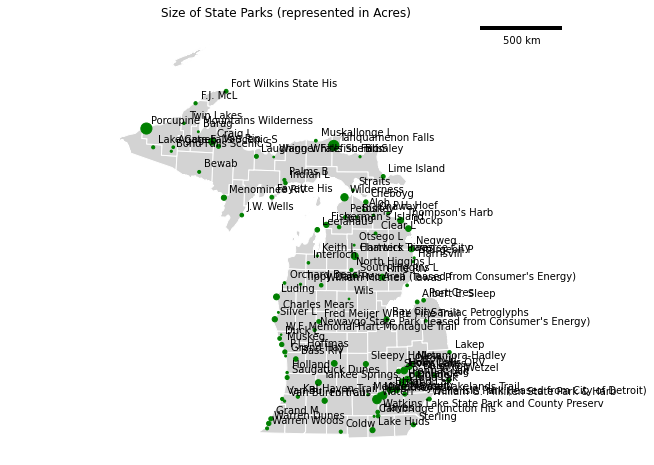

In [510]:
fig, ax = plt.subplots(figsize=(10,8))

#basemap- basic display of a geojson.
base.plot(ax=ax,
             facecolor='lightgray',
             edgecolor='white')

#symbols: Created from the centroids we computed from the state park polygons with the size based on the ACRES
symbols = park_centroids['size']

park_centroids.plot(ax=ax,
                   markersize=symbols,
                   color='green')

#text: Written out here for the first time
ax.set_title('Size of State Parks (represented in Acres)')

#scalebar: function from matplotlib
ax.add_artist(ScaleBar(1))

#labels: based on combination of centroids and the FACILITY info from stateparks_gdf
for x, y, label in zip(park_labels.geometry.x, park_labels.geometry.y, park_labels.FACILITY):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points")

ax.axis('equal')
ax.set_axis_off()
plt.show()

In [511]:
top_five= park_labels.nlargest(5, 'ACRES')
bottom_five = park_labels.nsmallest(5,'ACRES')
top_five

,geometry,ACRES,size,FACILITY
74,POINT (18330810.787 1302005.238),60066.859090,122.542706,Porcupine Mountains Wilderness
40,POINT (19476650.763 1197889.094),46799.947012,108.166477,Tahquamenon Falls
85,POINT (19740973.870 -354676.026),22109.861198,74.346925,Waterl
84,POINT (19779094.373 -329991.726),11851.957430,54.433348,Pinckney
33,POINT (19542218.115 881647.391),11391.427616,53.365316,Wilderness


In [512]:
conditions = [
    (park_labels['ACRES'] < 49),
    (park_labels['ACRES'] >= 11390),
    (park_labels['ACRES']>49) & (park_labels['ACRES']< 11390)]
values = ['Small Park', 'Large Park', '']

park_labels['NEWPARK'] = np.select(conditions, values)


In [513]:
park_labels
x = park_labels.loc[park_labels['NEWPARK']=='Small Park']
x

,geometry,ACRES,size,FACILITY,NEWPARK
7,POINT (19570058.457 259875.446),34.798751,2.949523,Wils,Small Park
24,POINT (19109440.036 1127986.037),34.912461,2.954338,Wagner Falls Scenic S,Small Park
27,POINT (20047576.530 -356002.018),28.731896,2.680107,William G. Milliken State Park & Harb,Small Park
30,POINT (19182174.965 -89431.042),48.514660,3.482623,Grand Hav,Small Park
59,POINT (19155004.812 41349.945),22.652271,2.379720,W.F. Memorial Hart-Montague Trail,Small Park


In [517]:
park_labels.loc[park_labels['NEWPARK'] =="Small Park", "NEWPARK"]=park_labels['FACILITY']
park_labels.loc[park_labels['NEWPARK'] =="Large Park", "NEWPARK"]=park_labels['FACILITY']
park_labels

,geometry,ACRES,size,FACILITY,NEWPARK
0,POINT (19068977.639 -531911.337),311.141471,8.819601,Warren Woods,
1,POINT (19963985.072 -509554.831),1245.541431,17.646115,Sterling,
2,POINT (19953455.668 -254093.890),77.098186,4.390279,Dodge 4,
3,POINT (19321673.876 480672.362),179.450770,6.697962,Interloch,
4,POINT (20184691.424 -66318.961),544.967155,11.672266,Lakep,
...,...,...,...,...,...
101,POINT (19861522.941 -296326.748),4126.112150,32.117410,Island Lak,
102,POINT (19719840.891 772051.181),133.409784,5.775158,Onaway,
103,POINT (19732132.232 660646.418),290.281487,8.518825,Clear L,
104,POINT (18648508.277 1282318.122),55.399613,3.721546,Barag,


In [518]:
x = park_labels.loc[(park_labels['NEWPARK']=='Small Park') | (park_labels['NEWPARK']=='Large Park')]
print(x)

Empty GeoDataFrame
Columns: [geometry, ACRES, size, FACILITY, NEWPARK]
Index: []


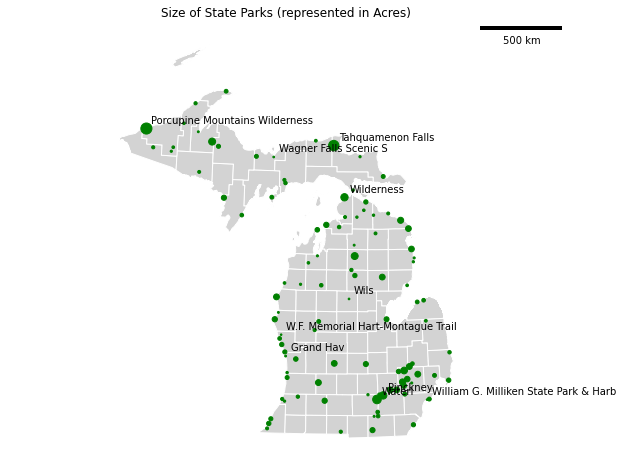

In [527]:
fig, ax = plt.subplots(figsize=(10,8))

#basemap- basic display of a geojson.
base.plot(ax=ax,
             facecolor='lightgray',
             edgecolor='white',
                )

#symbols: Created from the centroids we computed from the state park polygons with the size based on the ACRES
symbols = park_centroids['size']

park_centroids.plot(ax=ax,
                   markersize=symbols,
                   color='green',
                   )

#text: Written out here for the first time
ax.set_title('Size of State Parks (represented in Acres)')

#scalebar: function from matplotlib
ax.add_artist(ScaleBar(1))

#labels: based on combination of centroids and the FACILITY info from stateparks_gdf
for x, y, label in zip(park_labels.geometry.x, park_labels.geometry.y, park_labels.NEWPARK):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points")

ax.axis('equal')
ax.set_axis_off()
plt.show()